In [219]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs,\
                                  pad_seqs_2step, pad_seqs_1step, calculate_output, onehot2seq 

from sklearn.metrics import r2_score
import math

In [173]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    accs = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item()
                accs.append(correct)
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds, 'acc'+suffix: accs})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model

def change_padder(seqs, cue_dict, xval):
    """ changes value of X from zero to a new value
        and recalculates sequence output"""
    cue_dict['X'] = xval
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, cue_dict, bidmas = False))

    return inps, cue_dict

def change_dict(seqs, new_dict):
    """ recalculates sequence output"""
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, new_dict, bidmas = False))

    return inps, cue_dict

def predcorr(mods, tests):
    dfs1 = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        dfs1.append(df)
        all_dfs1 = pd.concat(dfs1) 
        preds, labs = all_dfs1['pred'], all_dfs1['label']
        xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

        for d in dfs1:
            plt.scatter(d['label'], d['pred'])
        plt.plot(xy,xy)
        plt.xlabel('Ground truth')
        plt.ylabel('Model prediction')
        plt.title('with primitive training, R^2 = ' + str(round(r2_score(all_dfs1['pred'],all_dfs1['label']), 2)) )
    
    return all_dfs1.groupby(['trial']).mean().sort_values(by = 'acc' , ascending=False)

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

In [174]:
def generate_other(operators, inputs, init_values, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        for init in init_values:
            input_ids = [val for val in inputs if val != init]
            combi_inputcue = list(itertools.combinations(input_ids, r=2))
            cue = random.choice(combi_inputcue)
            op = random.choice(combi_operators)
            trial = [init,*zip(tuple(op), cue)]
            trial.append(calculate_output(trial, cue_dict, False))
            seq.append(trial)

    return seq

def test_other(operators, test, syms, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        input_ids = [test] + [random.choice(syms)]
        random.shuffle(input_ids)
        combi_inputcue = list(itertools.combinations(input_ids, r=2))
        cue = random.choice(combi_inputcue)
        op = random.choice(combi_operators)
        trial = [random.choice(syms),*zip(tuple(op), cue)]
        trial.append(calculate_output(trial, cue_dict, False))
        seq.append(trial)

    return seq

def generate_self(operators, inputs, rep = 1):
    seq = []
    for _ in range(rep):
        for inp in inputs:
            trial = generate_sequences(operators, inp, len_seq = 2, cue_dict = cue_dict, init_values = inp)
            seq += trial
    return seq

def generate_dummy(operators, inputs, init_values, rep = 1):
    # remove init form inputs
    
    seq = []
    combi_operators = list(itertools.product(operators, repeat=2))
    for _ in range(rep):
        for init in init_values:
            input_ids = [val for val in inputs if val != init]
            inp = random.choice(input_ids)
            cue = (inp, inp)
            op = random.choice(combi_operators)
            trial = [init,*zip(tuple(op), cue)]
            trial.append(calculate_output(trial, cue_dict, False))
            seq.append(trial)

    return seq

In [175]:
# params

num_classes = 22
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
num_sims = 56
learningRate = 0.005
epochs = 1000

# Trigrams: Addition

In [180]:
def run_exp1(trainseqs_old, testseqs_old):
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,30))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs, cd = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    testseqs, cd = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)

    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset}

## Exp 1

---

In [181]:
num_inputs = 5

total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,30))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {'X':0}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]


In [182]:
ops = ['+']
p = pad_seqs_1step(all_syms, cue_dict)
trainseqs = pad_seqs_2step(generate_sequences(['+'], all_syms[1:], len_seq = 1, cue_dict = cue_dict, init_values = all_syms[1:])) + p
testseqs = test_other(ops, 'A', all_syms[1:], rep = 10)

time:  11.733542362848917


,label,pred,acc
trial,,,
"['C', '+', 'A', '+', 'C']",44.275,43.592388,0.375
"['E', '+', 'A', '+', 'C']",44.700,43.889712,0.350
"['D', '+', 'A', '+', 'C']",45.275,44.386682,0.325
"['B', '+', 'A', '+', 'B']",45.925,45.309115,0.300
"['C', '+', 'C', '+', 'A']",44.275,43.652990,0.250
"['C', '+', 'E', '+', 'A']",44.700,44.123284,0.225
"['E', '+', 'D', '+', 'A']",45.700,45.190409,0.225
"['B', '+', 'E', '+', 'A']",45.525,45.143215,0.200
"['E', '+', 'E', '+', 'A']",45.125,44.685873,0.200


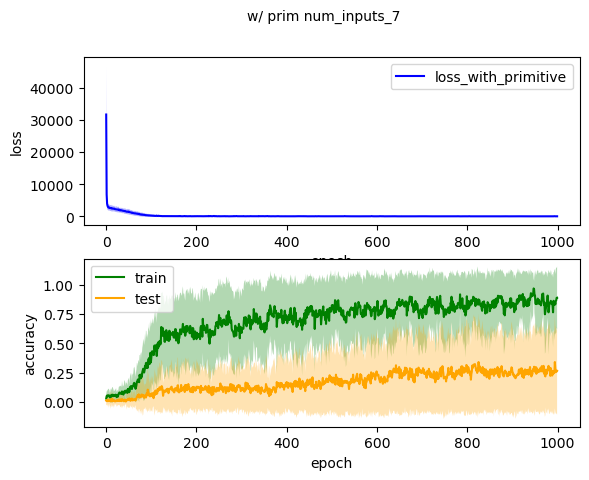

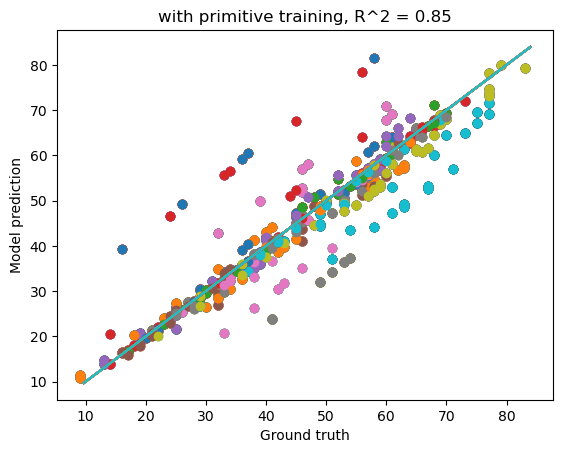

In [183]:
t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# Init type 1 : kaiming uniform 


In [184]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        
        self.initialize_weights()

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m , nn.Linear):
                nn.init.kaiming_uniform_(m.weight)


time:  12.037334668636323


,label,pred,acc
trial,,,
"['B', '+', 'E', '+', 'A']",47.175,44.111205,0.125
"['C', '+', 'C', '+', 'A']",46.700,43.655852,0.125
"['C', '+', 'E', '+', 'A']",45.425,42.478109,0.100
"['D', '+', 'A', '+', 'C']",45.850,42.953693,0.100
"['B', '+', 'A', '+', 'B']",50.200,46.762951,0.075
"['E', '+', 'A', '+', 'C']",45.425,42.623354,0.075
"['E', '+', 'D', '+', 'A']",44.575,41.492451,0.075
"['E', '+', 'E', '+', 'A']",44.150,41.188323,0.075
"['C', '+', 'A', '+', 'C']",46.700,44.099822,0.025


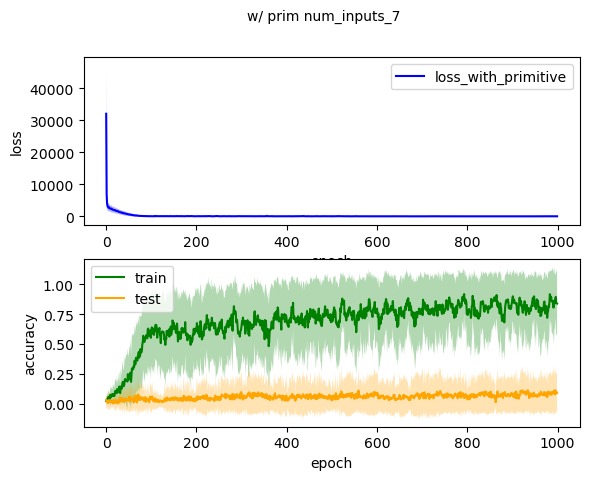

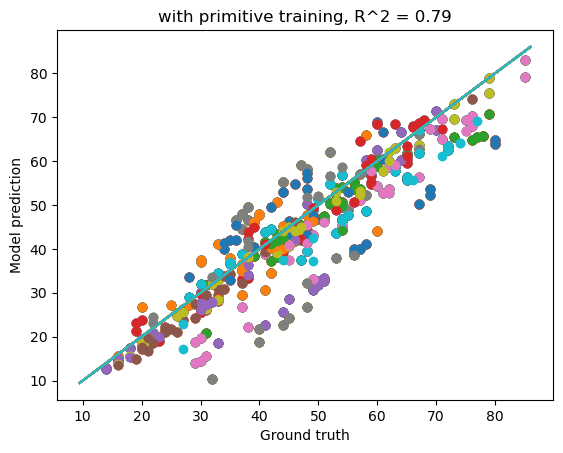

In [185]:
t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# Kaiming Normal

In [186]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        
        self.initialize_weights()

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m , nn.Linear):
                nn.init.kaiming_normal_(m.weight)


time:  11.996276263395945


,label,pred,acc
trial,,,
"['D', '+', 'A', '+', 'C']",46.350,42.788897,0.125
"['E', '+', 'A', '+', 'C']",47.550,44.196376,0.125
"['B', '+', 'A', '+', 'B']",44.275,40.993124,0.075
"['B', '+', 'E', '+', 'A']",46.375,41.545397,0.075
"['C', '+', 'A', '+', 'C']",46.625,43.243122,0.075
"['C', '+', 'E', '+', 'A']",47.550,42.766308,0.075
"['E', '+', 'D', '+', 'A']",47.275,42.733044,0.075
"['E', '+', 'E', '+', 'A']",48.475,43.915143,0.075
"['C', '+', 'C', '+', 'A']",46.625,41.810737,0.050


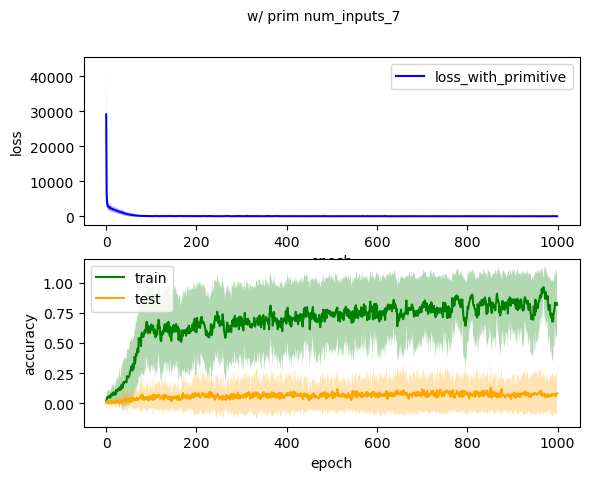

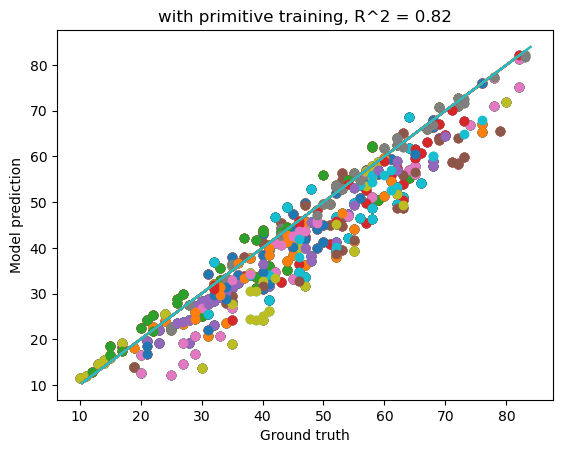

In [187]:
t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# Xavier uniform

In [188]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)


time:  12.75621039867401


,label,pred,acc
trial,,,
"['C', '+', 'A', '+', 'C']",44.425,41.236428,0.225
"['B', '+', 'A', '+', 'B']",44.375,41.450128,0.200
"['E', '+', 'A', '+', 'C']",46.425,43.396895,0.175
"['C', '+', 'C', '+', 'A']",44.425,40.243478,0.150
"['D', '+', 'A', '+', 'C']",45.225,41.984237,0.150
"['C', '+', 'E', '+', 'A']",46.425,42.063096,0.125
"['E', '+', 'D', '+', 'A']",47.225,42.889977,0.125
"['E', '+', 'E', '+', 'A']",48.425,44.218592,0.125
"['B', '+', 'E', '+', 'A']",46.400,41.962075,0.100


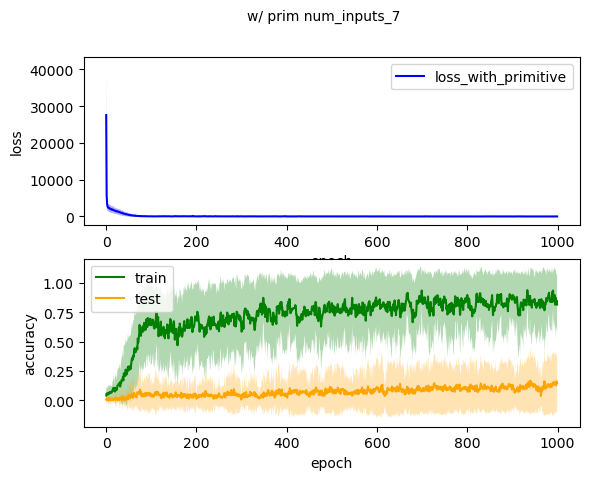

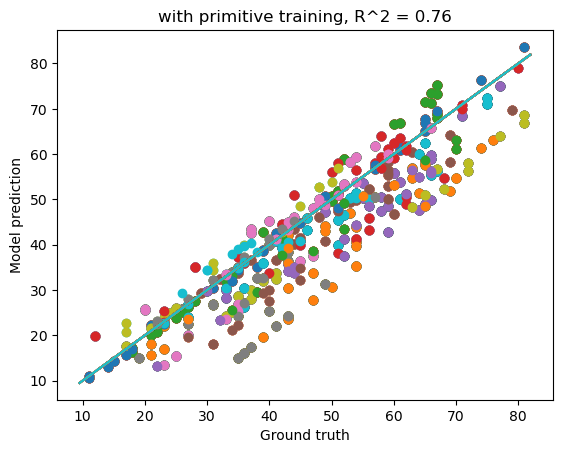

In [189]:
t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

# Xavier Normal

In [190]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 1)


time:  7.191423622767131


,label,pred,acc
trial,,,
"['C', '+', 'C', '+', 'A']",46.25,44.639133,0.175
"['D', '+', 'A', '+', 'C']",46.15,44.529839,0.175
"['B', '+', 'A', '+', 'B']",43.05,41.594123,0.150
"['B', '+', 'E', '+', 'A']",44.05,42.306168,0.125
"['E', '+', 'A', '+', 'C']",45.65,43.865931,0.125
"['C', '+', 'A', '+', 'C']",46.25,44.822855,0.100
"['C', '+', 'E', '+', 'A']",45.65,43.992249,0.100
"['E', '+', 'D', '+', 'A']",45.55,43.783083,0.100
"['E', '+', 'E', '+', 'A']",45.05,43.501541,0.075


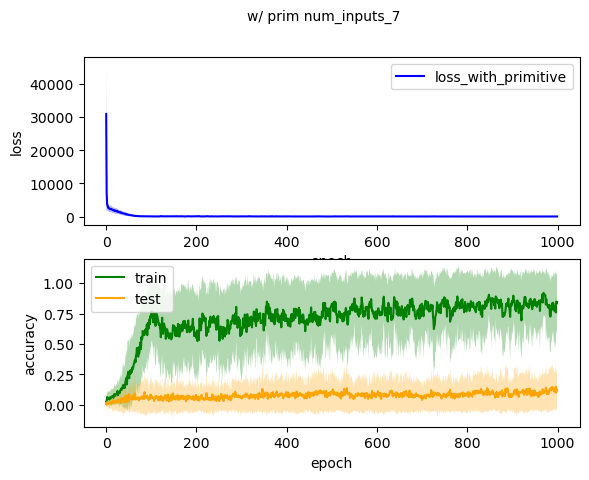

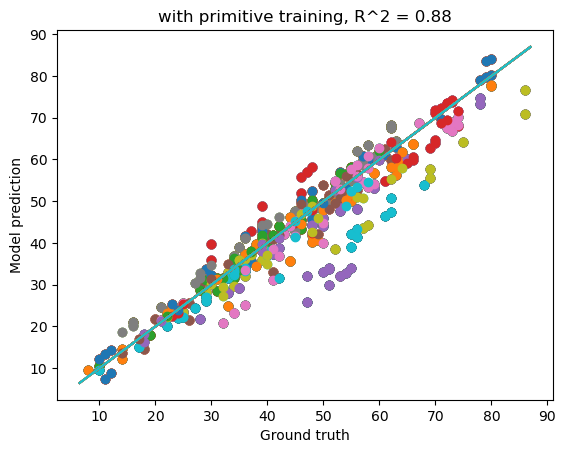

In [191]:
t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [237]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        y = 1/math.sqrt(hidden_size)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 0.001)


time:  6.350304750601451


,label,pred,acc
trial,,,
"['C', '+', 'A', '+', 'C']",47.175,46.702803,0.625
"['E', '+', 'D', '+', 'A']",44.025,43.591638,0.625
"['C', '+', 'C', '+', 'A']",47.175,46.608451,0.600
"['C', '+', 'E', '+', 'A']",46.875,46.420142,0.600
"['E', '+', 'A', '+', 'C']",46.875,46.453790,0.600
"['E', '+', 'E', '+', 'A']",46.575,46.157032,0.600
"['B', '+', 'E', '+', 'A']",45.975,45.536427,0.575
"['D', '+', 'A', '+', 'C']",44.325,43.784689,0.575
"['B', '+', 'A', '+', 'B']",45.375,44.992504,0.525


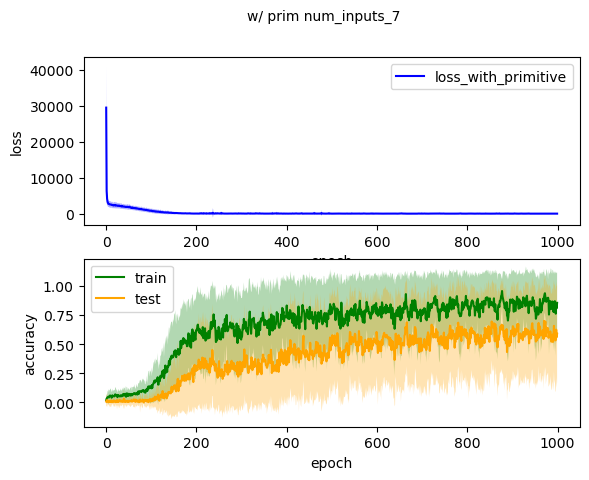

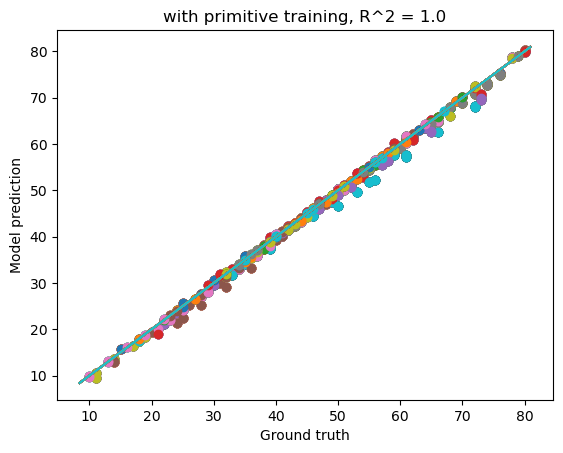

In [238]:
t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

In [241]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)
        self.initialize_weights()
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]
    
    def initialize_weights(self):
        y = 1/math.sqrt(hidden_size)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, 100)


In [ ]:
t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss'] for r in res])
acc_train = np.array([r['acc'][:,0] for r in res]).T
acc_test = np.array([r['acc'][:,1] for r in res]).T
mods = [r['mod'] for r in res]
tests = [r['test'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plt.figure()
predcorr(mods, tests)

time:  15.69071043729782
